## 0. Define function

In [2]:
import trimesh
import numpy as np

import os
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.spatial.transform import Rotation as R
import time
import pickle
import argparse
from utils import *
import matplotlib 
from matplotlib import pyplot as plt
from tqdm import tqdm
from deepVCP import DeepVCP
from deepVCP_loss import get_rigid_transform 
import open3d as o3d
import copy

In [3]:
src_pts = trimesh.load('./meshes/bun000_v2.ply')

In [4]:
def cal_boundinbox_len(model):
    x_len = np.amax(model[:,0]) - np.amin(model[:,0])
    y_len = np.amax(model[:,1]) - np.amin(model[:,1])
    z_len = np.amax(model[:,2]) - np.amin(model[:,2])
    diag_len_bounding_box = np.sqrt(x_len * x_len + y_len * y_len + z_len * z_len)
    return diag_len_bounding_box

In [5]:
def generate_G_t(model, diag_len_bounding_box):
    theta_x = np.random.uniform(0, np.pi/5)
    theta_y = np.random.uniform(0, np.pi/5)
    theta_z = np.random.uniform(0, np.pi/5)
    
    # generate random translation
    translation_max = diag_len_bounding_box * 0.3
    translation_min = diag_len_bounding_box  * 0.3
    t = np.random.uniform(translation_min, translation_max, (3, 1))
    Rx = RotX(theta_x)
    Ry = RotY(theta_y)
    Rz = RotZ(theta_z)
    R = Rx @ Ry @ Rz
    target_points = R @ model.T + t
    return target_points, R, t

In [66]:
def display1(input, str = None):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    color='b'
    ax.scatter(input[:,0], input[:,1], -input[:,2], c=color, marker='.', s=1)
    if str is not None:
        plt.title(str)
    plt.show()

In [6]:
def display2(inputs, str = None):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors=['b','r']
    for idx, input in enumerate(inputs):
        ax.scatter(input[:,0], input[:,1], -input[:,2], c=colors[idx], marker='.', s=1)
    if str is not None:
        plt.title(str)
    plt.show()

In [7]:
def calculate_mse(img1, img2):
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    return  mse

In [8]:
def build_trans_matrix(R, t):
    trans_matrix = np.zeros(shape = (4, 4))
    trans_matrix[:3, :3] = R
    trans_matrix[:3, 3] = t.flatten()
    trans_matrix[3, 3] = 1
    return trans_matrix

## 1. Visualise test result

In [9]:
src = src_pts.sample(10000)
boundingbox_len = cal_boundinbox_len(src)
targets, R, t = generate_G_t(src, boundingbox_len)

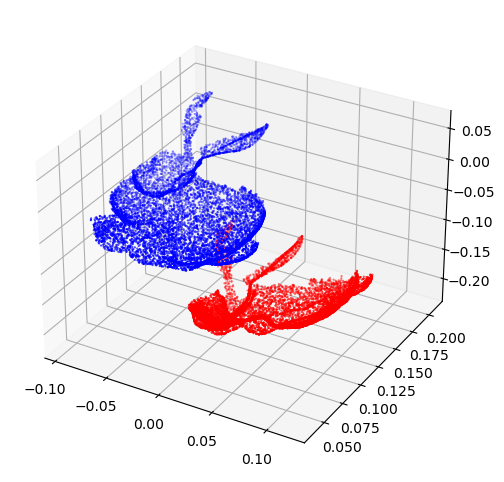

In [10]:
display2([src, targets.T])

In [11]:
R_prior = R.copy()
bias = np.pi/6
theta_x = np.random.uniform(-bias, bias)
theta_y = np.random.uniform(-bias, bias)
theta_z = np.random.uniform(-bias, bias)
Rx = RotX(theta_x)
Ry = RotY(theta_y)
Rz = RotZ(theta_z)
R_noise = Rx @ Ry @ Rz
R_prior = R_prior @ R_noise
t_init =  torch.randn((1, 3)).cuda()

In [14]:
trans_true = build_trans_matrix(R, t)
trans_prior = build_trans_matrix(R_prior, t_init.cpu().numpy())

In [15]:
deepvcp_model = DeepVCP(use_normal=False).cuda()
deepvcp_model.load_state_dict(torch.load('train2_epoch_19_model.pt', map_location='cuda'))

<All keys matched successfully>

In [16]:
R_prior = torch.from_numpy(R_prior).cuda()#.unsqueeze(0)
src_xyz = torch.from_numpy(src.T).unsqueeze(0).cuda()
target_xyz = torch.from_numpy(targets).unsqueeze(0).cuda()
deepvcp_model.eval()
with torch.no_grad():
    src_keypts, target_vcp = deepvcp_model(src_xyz, target_xyz, R_prior, t_init)

feature extraction time:  7.90863037109375
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.017940282821655273
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([ 990, 7643,  169,  ..., 7688, 6465, 3888], device='cuda:0')
get_cat_feat_tgt time:  0.09567928314208984


c:\Users\bingwang\.conda\envs\3D\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
R_pred, t_pred = get_rigid_transform(src_keypts.permute(0,2,1).float(), target_vcp.permute(0,2,1).float())

In [18]:
src_t = torch.matmul(R_pred, src_xyz.float()) + t_pred
src_t = src_t.permute(0,2,1).cpu().numpy()[0].astype(np.float64)
z = np.array(targets.T)
org = (R_prior@src_xyz[0]).T.cpu().numpy()

Text(0.5, 1.0, 'DeepVCP result')

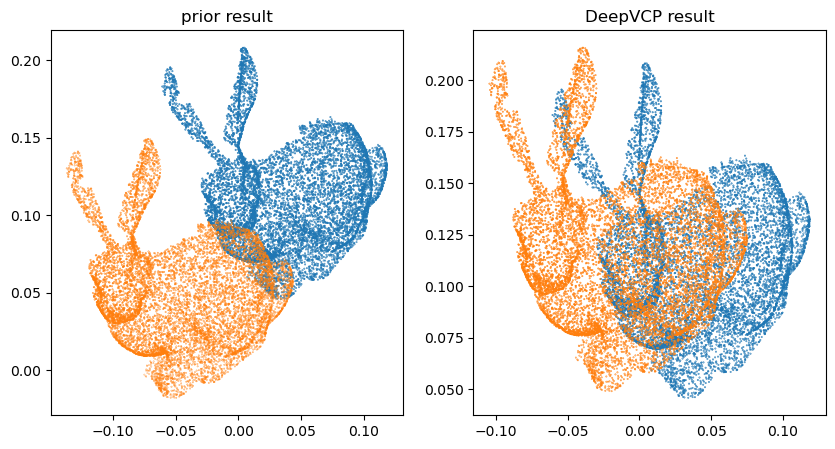

In [19]:
plt.figure(figsize=(10.0, 5.0))
plt.subplot(1, 2, 1)
plt.scatter(z[:,0], z[:,1], z[:,2])
plt.scatter(org[:,0], org[:,1], org[:,2])
plt.title('prior result')

plt.subplot(1, 2, 2)
plt.scatter(z[:,0], z[:,1], z[:,2])
plt.scatter(src_t[:,0], src_t[:,1], src_t[:,2])
plt.title('DeepVCP result')


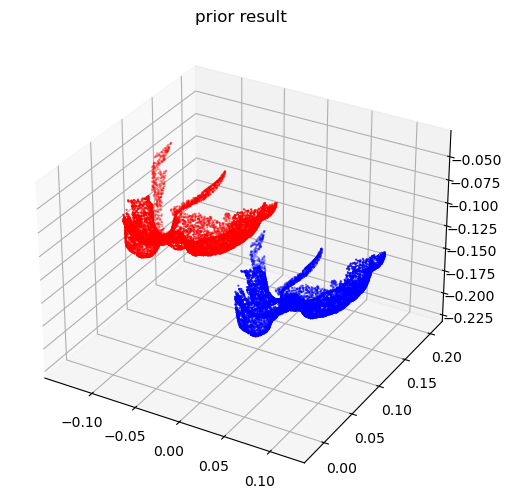

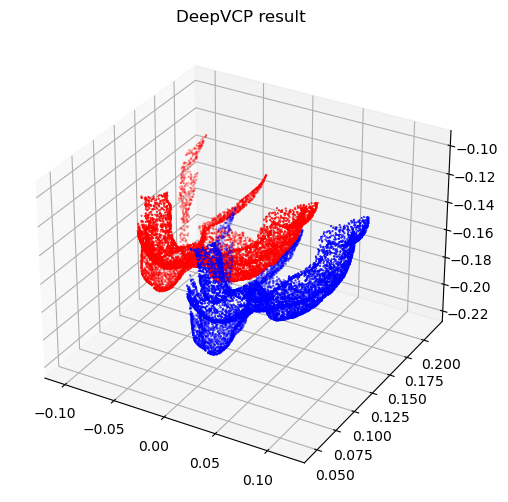

In [20]:
display2([z, org], str = 'prior result')
display2([z, src_t], str = 'DeepVCP result')

In [21]:
trans_pred = build_trans_matrix(R_pred.cpu().numpy(), t_pred.cpu().numpy())
print('MSE error:', calculate_mse(trans_true, trans_pred))

MSE error: 0.006375152


## 2. Compare with ICP

In [22]:
trans_init = trans_prior.copy()

In [23]:
no_trans = np.eye(4,4)
# trans_init = no_trans

In [24]:
src_pcd = o3d.geometry.PointCloud()
src_pcd.points = o3d.utility.Vector3dVector(src_pts.vertices)
target_pcd = o3d.geometry.PointCloud()
target_pcd.points = o3d.utility.Vector3dVector(targets.T)
reg_p2p = o3d.pipelines.registration.registration_icp(
    src_pcd, target_pcd, 5.5, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())

reg_p2p_comb = o3d.pipelines.registration.registration_icp(
    src_pcd, target_pcd, 5.5, trans_pred,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())

In [25]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [26]:
draw_registration_result(src_pcd, target_pcd, reg_p2p.transformation)

In [27]:
draw_registration_result(src_pcd, target_pcd, trans_pred)

In [28]:
draw_registration_result(src_pcd, target_pcd, reg_p2p_comb.transformation)

## 3. Global registration

### a. load data

In [ ]:
deepvcp_model.load_state_dict(torch.load('train2_epoch_19_model.pt', map_location='cuda'))

In [29]:
bunny_000 = trimesh.load('./meshes/bun000_v2.ply')
bunny_045 = trimesh.load('./meshes/bun045_v2.ply')
bunny_090 = trimesh.load('./meshes/bun090_v2.ply')
bunny_180 = trimesh.load('./meshes/bun180_v2.ply')
bunny_270 = trimesh.load('./meshes/bun270_v2.ply')
bunny_315 = trimesh.load('./meshes/bun315_v2.ply')

In [30]:
MODEL_dict = {'bunny_000' : bunny_000, 'bunny_045' : bunny_045, 'bunny_090': bunny_090, 
              'bunny_180': bunny_180, 'bunny_270': bunny_270, 'bunny_315':bunny_315}

In [31]:
print(MODEL_dict.keys())

dict_keys(['bunny_000', 'bunny_045', 'bunny_090', 'bunny_180', 'bunny_270', 'bunny_315'])


In [32]:
MODEL_dict['bunny_090'].show()

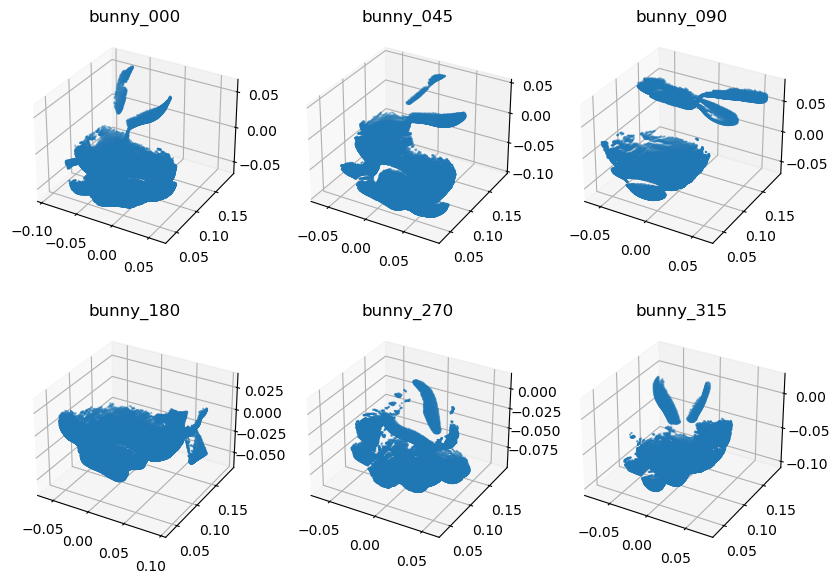

In [33]:
fig = plt.figure(figsize = (10.0, 7.0))
N_model = len(MODEL_dict)
for idx, key in enumerate(MODEL_dict):
    model = MODEL_dict[key]
    ax = fig.add_subplot(2, (N_model - 1) // 2 + 1, idx + 1, projection='3d')
    input = model.vertices
    ax.scatter(input[:,0], input[:,1], -input[:,2], marker='.', s=1)
    ax.set_title(key)

### b. global registration

In [54]:
# deepvcp_model.load_state_dict(torch.load('train2_epoch_1_model.pt', map_location='cuda'))
deepvcp_model.load_state_dict(torch.load('epoch_7_model.pt', map_location='cuda'))

<All keys matched successfully>

In [55]:
def apply_DeepVCP(src_pts, targets_pts, R_prior = None):
    indices = np.random.choice(src_pts.shape[0], 10000)
    src = src_pts[indices]
    indices = np.random.choice(src_pts.shape[0], 10000)
    targets = targets_pts[indices]
    src_xyz = torch.from_numpy(src.T).unsqueeze(0).cuda()
    target_xyz = torch.from_numpy(targets.T).unsqueeze(0).cuda()
    deepvcp_model.eval()

    if R_prior is None:
        R_prior = np.eye(3, 3)

    R_prior = torch.from_numpy(R_prior).cuda()

    with torch.no_grad():
        src_keypts, target_vcp = deepvcp_model(src_xyz, target_xyz, R_prior, t_init)
    R_pred, t_pred = get_rigid_transform(src_keypts.permute(0,2,1).float(), target_vcp.permute(0,2,1).float())
    trans_pred = build_trans_matrix(R_pred.cpu().numpy(), t_pred.cpu().numpy())
    return trans_pred, R_pred.cpu().numpy(), t_pred.cpu().numpy()

In [56]:
global_model = MODEL_dict['bunny_000'].vertices
for idx, key in tqdm(enumerate(MODEL_dict)):
    print(key)
    model = MODEL_dict[key].vertices
    if idx == 0:
        global_model = model
        continue
    trans_pred_tmp, R_tmp, t_tmp = apply_DeepVCP(model, global_model)
    align_model = (R_tmp@model.T).T + t_tmp
    global_model = np.concatenate((global_model, align_model.squeeze()), axis=0)

0it [00:00, ?it/s]

bunny_000
bunny_045
feature extraction time:  6.726563453674316
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.01993274688720703
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0


2it [00:13,  6.54s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([8409, 9922,  241,  ..., 8033, 4284, 1315], device='cuda:0')
get_cat_feat_tgt time:  0.09069657325744629
bunny_090
feature extraction time:  6.08178973197937
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.01694345474243164
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0009961128234863281


3it [00:25,  9.00s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([6236, 4419, 3998,  ..., 1909, 5594, 6394], device='cuda:0')
get_cat_feat_tgt time:  0.07774090766906738
bunny_180
feature extraction time:  6.4924156665802
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.013983726501464844
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0010006427764892578


4it [00:38, 10.55s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([ 369, 1989, 4401,  ..., 4378, 8326, 5227], device='cuda:0')
get_cat_feat_tgt time:  0.11508679389953613
bunny_270
feature extraction time:  6.690633296966553
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.018936634063720703
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0


5it [00:52, 11.54s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([6473, 5926, 8312,  ..., 5572, 4121, 9769], device='cuda:0')
get_cat_feat_tgt time:  0.0828256607055664
bunny_315
feature extraction time:  6.490434169769287
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.020930051803588867
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0


6it [01:04, 10.80s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([7960, 2257, 7114,  ..., 4267, 6970, 5387], device='cuda:0')
get_cat_feat_tgt time:  0.0817267894744873


c:\Users\bingwang\.conda\envs\3D\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


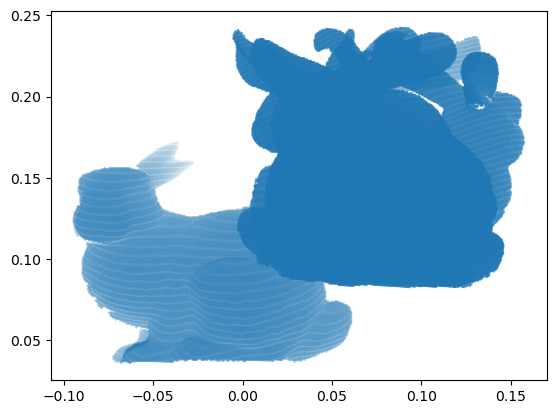

In [57]:
plt.scatter(global_model[:,0], global_model[:,1], global_model[:,2])

ICP global

In [58]:
global_model = MODEL_dict['bunny_000'].vertices
for idx, key in tqdm(enumerate(MODEL_dict)):
    print(key)
    model = MODEL_dict[key].vertices
    if idx == 0:
        global_model = model
        continue

    trans_init = np.eye(4, 4)
    src_pcd = o3d.geometry.PointCloud()
    src_pcd.points = o3d.utility.Vector3dVector(model)
    target_pcd = o3d.geometry.PointCloud()
    target_pcd.points = o3d.utility.Vector3dVector(global_model)
    
    reg_p2p_tmp = o3d.pipelines.registration.registration_icp(
        src_pcd, target_pcd, 5.5, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    trans = reg_p2p_tmp.transformation
    R_tmp = trans[:3, :3]
    t_tmp = trans[:3, 3]
    align_model = (R_tmp @ model.T).T + t_tmp
    global_model = np.concatenate((global_model, align_model.squeeze()), axis=0)


2it [00:00, 11.60it/s]

bunny_000
bunny_045
bunny_090


4it [00:01,  2.12it/s]

bunny_180
bunny_270


6it [00:02,  2.23it/s]

bunny_315


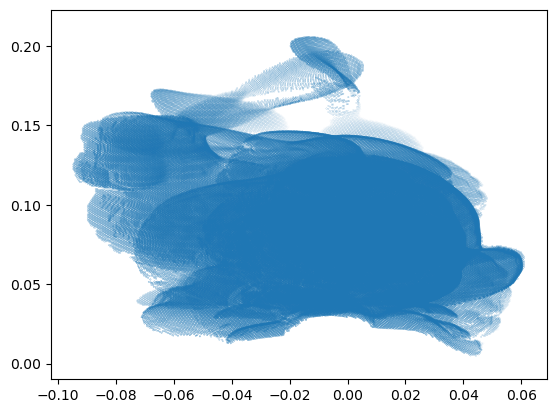

In [59]:
plt.scatter(global_model[:,0], global_model[:,1], global_model[:,2])

In [72]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [76]:
def prepare_dataset(voxel_size, source, target):
    print(":: Load two point clouds and disturb initial pose.")

    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

In [86]:
src_pcd = o3d.geometry.PointCloud()
src_pcd.points = o3d.utility.Vector3dVector(MODEL_dict['bunny_000'].vertices)
target_pcd = o3d.geometry.PointCloud()
target_pcd.points = o3d.utility.Vector3dVector(MODEL_dict['bunny_045'].vertices)
    
voxel_size = 0.005  # means 5cm for this dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
    voxel_size, src_pcd, target_pcd)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.005.
:: Estimate normal with search radius 0.010.
:: Compute FPFH feature with search radius 0.025.
:: Downsample with a voxel size 0.005.
:: Estimate normal with search radius 0.010.
:: Compute FPFH feature with search radius 0.025.


In [89]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3)
    return result

In [90]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.005,
   we use a liberal distance threshold 0.007.


TypeError: registration_ransac_based_on_feature_matching(): incompatible function arguments. The following argument types are supported:
    1. (source: open3d.cpu.pybind.geometry.PointCloud, target: open3d.cpu.pybind.geometry.PointCloud, source_feature: open3d::pipelines::registration::Feature, target_feature: open3d::pipelines::registration::Feature, max_correspondence_distance: float, estimation_method: open3d.cpu.pybind.pipelines.registration.TransformationEstimation = TransformationEstimationPointToPoint without scaling., ransac_n: int = 4, checkers: List[open3d.cpu.pybind.pipelines.registration.CorrespondenceChecker] = [], criteria: open3d.cpu.pybind.pipelines.registration.RANSACConvergenceCriteria = RANSACConvergenceCriteria class with max_iteration=100000, and max_validation=100) -> open3d.cpu.pybind.pipelines.registration.RegistrationResult

Invoked with: PointCloud with 1404 points., PointCloud with 1334 points., Feature class with dimension = 33 and num = 1404
Access its data via data member., Feature class with dimension = 33 and num = 1334
Access its data via data member., True, 0.0075, TransformationEstimationPointToPoint without scaling., 3

In [84]:
global_model = MODEL_dict['bunny_000'].vertices
for idx, key in tqdm(enumerate(MODEL_dict)):
    print(key)
    model = MODEL_dict[key].vertices
    if idx == 0:
        global_model = model
        continue

    trans_init = np.eye(4, 4)
    
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3)
    # result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    #     source_down, target_down, source_fpfh, target_fpfh, True,
    #     distance_threshold,
    #     o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
    #     3, [
    #         o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
    #             0.9),
    #         o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
    #             distance_threshold)
    #     ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))

    # result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
    #     src_pcd.points, target_pcd.points,
    #     o3d.pipelines.registration.FastGlobalRegistrationOption(
    #         maximum_correspondence_distance=distance_threshold))

    trans = result.transformation
    R_tmp = trans[:3, :3]
    t_tmp = trans[:3, 3]
    align_model = (R_tmp @ model.T).T + t_tmp
    global_model = np.concatenate((global_model, align_model.squeeze()), axis=0)


1it [00:01,  1.59s/it]

bunny_000
bunny_045
:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.


TypeError: registration_ransac_based_on_feature_matching(): incompatible function arguments. The following argument types are supported:
    1. (source: open3d.cpu.pybind.geometry.PointCloud, target: open3d.cpu.pybind.geometry.PointCloud, source_feature: open3d::pipelines::registration::Feature, target_feature: open3d::pipelines::registration::Feature, max_correspondence_distance: float, estimation_method: open3d.cpu.pybind.pipelines.registration.TransformationEstimation = TransformationEstimationPointToPoint without scaling., ransac_n: int = 4, checkers: List[open3d.cpu.pybind.pipelines.registration.CorrespondenceChecker] = [], criteria: open3d.cpu.pybind.pipelines.registration.RANSACConvergenceCriteria = RANSACConvergenceCriteria class with max_iteration=100000, and max_validation=100) -> open3d.cpu.pybind.pipelines.registration.RegistrationResult

Invoked with: PointCloud with 20786 points., PointCloud with 21519 points., Feature class with dimension = 33 and num = 20786
Access its data via data member., Feature class with dimension = 33 and num = 21519
Access its data via data member., True, 0.0005, TransformationEstimationPointToPoint without scaling., 3

In [ ]:
display1(global_model)

vcp&icp

In [60]:
global_model = MODEL_dict['bunny_000'].vertices
for idx, key in tqdm(enumerate(MODEL_dict)):
    print(key)
    model = MODEL_dict[key].vertices
    if idx == 0:
        global_model = model
        continue

    trans_pred_tmp, R_tmp, t_tmp = apply_DeepVCP(model, global_model)
    trans_init = trans_pred_tmp

    src_pcd = o3d.geometry.PointCloud()
    src_pcd.points = o3d.utility.Vector3dVector(model)
    target_pcd = o3d.geometry.PointCloud()
    target_pcd.points = o3d.utility.Vector3dVector(global_model)
    
    reg_p2p_tmp = o3d.pipelines.registration.registration_icp(
        src_pcd, target_pcd, 5.5, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    trans = reg_p2p_tmp.transformation
    R_tmp = trans[:3, :3]
    t_tmp = trans[:3, 3]
    align_model = (R_tmp @ model.T).T + t_tmp
    global_model = np.concatenate((global_model, align_model.squeeze()), axis=0)


0it [00:00, ?it/s]

bunny_000
bunny_045
feature extraction time:  7.24079442024231
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.019933462142944336
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0009965896606445312
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([9762, 7248, 4316,  ..., 5326, 3905, 7115], device='cuda:0')
get_cat_feat_tgt time:  0.0877068042755127


2it [00:14,  7.29s/it]

bunny_090
feature extraction time:  6.682649374008179
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.021927595138549805
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0009963512420654297
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([ 613, 1375,  790,  ..., 7976,  878, 1168], device='cuda:0')
get_cat_feat_tgt time:  0.08073043823242188


3it [00:28, 10.02s/it]

bunny_180
feature extraction time:  6.662820816040039
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.014950275421142578
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([ 524, 8160, 6056,  ..., 8207, 8953, 3794], device='cuda:0')
get_cat_feat_tgt time:  0.09282732009887695


4it [00:42, 11.51s/it]

bunny_270
feature extraction time:  6.291956186294556
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.01594686508178711
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([8876, 4613,  963,  ..., 6478, 5487, 6657], device='cuda:0')
get_cat_feat_tgt time:  0.08372020721435547


5it [00:55, 12.05s/it]

bunny_315
feature extraction time:  6.399722576141357
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.014950275421142578
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([1732,  737, 6385,  ..., 2043, 6277,  297], device='cuda:0')
get_cat_feat_tgt time:  0.08278322219848633


6it [01:09, 11.52s/it]


c:\Users\bingwang\.conda\envs\3D\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


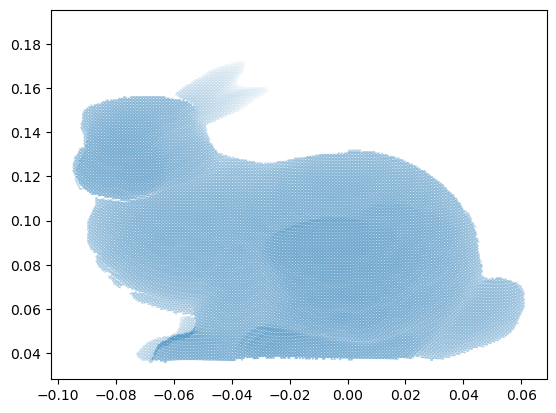

In [63]:
plt.scatter(global_model[:,0], global_model[:,1], global_model[:,2])

## 4. Add gaussian noise

In [ ]:
def add_noise(model, noise_rate):
    x_len = np.amax(model[:,0]) - np.amin(model[:,0])
    y_len = np.amax(model[:,1]) - np.amin(model[:,1])
    z_len = np.amax(model[:,2]) - np.amin(model[:,2])
    diag_len_bounding_box = np.sqrt(x_len * x_len + y_len * y_len + z_len * z_len)
    # Add noise
    std = noise_rate * diag_len_bounding_box
    noise_model = model + np.random.normal(0, std, model.shape)
    return noise_model